In [29]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import ipywidgets as widgets

In [30]:
#import data
google_2020 = pd.read_csv('Data/2020_US_Region_Mobility_Report.csv')
google_2021 = pd.read_csv('Data/2021_US_Region_Mobility_Report.csv')
lockdown = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_latest.csv')

Concatenate the 2020 dataset and 2021 dataset

In [3]:
google_df = pd.concat([google_2020,google_2021])

In [4]:
#Change column names
cols = ['retail_and_recreation_percent_change_from_baseline',
            'grocery_and_pharmacy_percent_change_from_baseline',
            'parks_percent_change_from_baseline',
            'transit_stations_percent_change_from_baseline',
            'workplaces_percent_change_from_baseline',
            'residential_percent_change_from_baseline']

new_cols = ['Retail and Recreation','Grocery and Pharmacy','Parks', 
            'Transit Stations','Workplaces','Residential']

col_dict =  {cols[i] : new_cols[i] for i in range(len(new_cols))}

google_df = google_df.rename(columns = col_dict)

In [5]:
#Change the type of the date column
google_df['date'] = pd.to_datetime(google_df['date'], format = '%Y-%m-%d')

In [6]:
#change column names of lockdown dataset
lockdown = lockdown.rename(columns = {'RegionName':'sub_region_1', 'Date':'date'})

In [7]:
#change the type of date column
lockdown['date'] = pd.to_datetime(lockdown['date'], format = '%Y%m%d')

Google mobility dataset (National level)

In [8]:
google_US_df = google_df[google_df['sub_region_1'].isnull()].copy()
# we'll also drop the uncessary columns
google_US_df.drop(columns=['country_region_code', 'sub_region_1', 'sub_region_2', 
                           'iso_3166_2_code', 'census_fips_code', 'place_id', 'metro_area'], 
                  inplace=True)

Lockdown dataset (National level)

In [9]:
lockdown_US_df = lockdown[lockdown['sub_region_1'].isnull()].copy()

In [10]:
#daily cases and deaths
lockdown_US_df[['DailyCases','DailyDeaths']]= lockdown_US_df[['ConfirmedCases','ConfirmedDeaths']].diff().fillna(0)


Merge Google mobility data and lockdown data (National level)

In [11]:
google_lockdown_US = lockdown_US_df.merge(google_US_df, on = 'date', how = 'inner')

Merge Google mobility data and lockdown data (State level)

In [12]:
google_states = google_df[~google_df['sub_region_1'].isnull() 
                          & google_df['sub_region_2'].isnull()].copy()
lockdown_states = lockdown[~lockdown['sub_region_1'].isnull()].copy()

google_lockdown = google_states.merge(lockdown_states, on = ['date','sub_region_1'])


## Line graph
### Mobility percentage change from baseline by destination - Figure 4

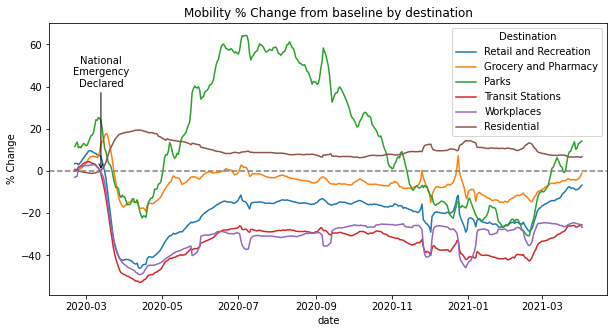

In [13]:
df = google_lockdown_US[new_cols+['date']].set_index('date').rolling(7).mean().dropna()
df = df.reset_index()
lockdownstart = date2num(google_lockdown_US['date'][27])
google_US_melt = df[['date']+new_cols].melt('date', var_name = 'Destination', value_name = '% Change')
fig, ax1 = plt.subplots(figsize = (10,5))
sns.lineplot(data = google_US_melt, x = 'date', y = '% Change', hue = 'Destination')
ax1.axhline( y = 0, color = 'gray', linestyle = '--')
ax1.annotate(
'National\nEmergency\nDeclared', xy=(lockdownstart, 0),xytext=(lockdownstart, 40) ,
horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=1)
)
plt.title("Mobility % Change from baseline by destination");

### Mobility vs. Stringency index by destination (National level) - Figure 5

In [14]:
def line2(Destination):
    
    df = google_lockdown_US[new_cols+['date','DailyCases']].set_index('date').rolling(7).mean().dropna()
    df = df.reset_index()
    lockdownstart = date2num(google_lockdown_US['date'][27])
    lockdownstart2 = date2num(google_lockdown_US['date'][57])
    
    fig, ax1 = plt.subplots(figsize = (10,5))
    sns.lineplot(x = 'date', y = Destination, data = df, ax = ax1, 
                 color = '#11836A', label = Destination)
    ax2 = ax1.twinx()
    sns.lineplot(x = 'date', y = 'StringencyIndex', data = google_lockdown_US, 
                 ax = ax2, color= '#BC2F0E', label = 'Stringency Index')

    locator = mdates.MonthLocator()  #every month
    fmt = mdates.DateFormatter('%b')
    X = ax2.xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
    ax1.set(xlim = (date2num(google_lockdown_US['date'].iloc[0]),
                    date2num(google_lockdown_US['date'].iloc[-1])))
    ax1.set(ylim=(-100, 100))
    ax2.set(ylim = (0,45))
    ax1.axhline( y = 0, color = 'gray', linestyle = '--')
    #plt.title("% Change from the baseline - " + Destination)
    ax1.annotate(
    'National\nEmergency\nDeclared', xy=(lockdownstart, 0),xytext=(lockdownstart2, 40) ,
    horizontalalignment="center",
    arrowprops=dict(arrowstyle='->',lw=2)
    )
    
    ax1.set_ylabel("% Change from Baseline - "+Destination)
    ax2.set_ylabel('Stringency Index')
    ax1.set_xlabel('Date')
    
    ax1.legend(loc = (0.72, 0.06), frameon = False)
    ax2.legend(loc = (0.72, 0.01), frameon = False)

    plt.show()

widgets.interact(line2, Destination = new_cols);


interactive(children=(Dropdown(description='Destination', options=('Retail and Recreation', 'Grocery and Pharm…

### Mobility vs. Daily cases by destination (National level) - Figure 6

In [15]:
def line3(Destination):
    
    df = google_lockdown_US[new_cols+['date','DailyCases']].set_index('date').rolling(7).mean().dropna()
    df = df.reset_index()
    fig, ax1 = plt.subplots(figsize = (10,5))
    
    lockdownstart = date2num(google_lockdown_US['date'][27])
    lockdownstart2 = date2num(google_lockdown_US['date'][57])
    
    sns.lineplot(x = 'date', y = Destination, data = df, ax = ax1, color = '#11836A', label = Destination)

    ax2 = ax1.twinx()

    sns.lineplot(x = 'date', y = 'DailyCases', data = df, ax = ax2, color= '#006aa3', label = "Daily Cases")
    locator = mdates.MonthLocator() 
    fmt = mdates.DateFormatter('%b')
    X = ax2.xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
    ax1.set(xlim = (date2num(google_lockdown_US['date'].iloc[0]),
                    date2num(google_lockdown_US['date'].iloc[-1])))
    ax1.set(ylim=(-100, 100))
    ax2.set(ylim = (0,max(df['DailyCases']+5000)))
    ax1.axhline( y = 0, color = 'gray', linestyle = '--')
    
    ax1.annotate(
    'National\nEmergency\nDeclared', xy=(lockdownstart, 0),xytext=(lockdownstart2, 40) ,
    horizontalalignment="center",
    arrowprops=dict(arrowstyle='->',lw=2)
    )

    ax1.set_ylabel("% Change from Baseline - "+Destination)
    ax2.set_ylabel('Daily Cases')  
    ax1.set_xlabel('Date')
    
    ax1.legend(loc = (0.72, 0.06), frameon = False)
    ax2.legend(loc = (0.72, 0.01), frameon = False)

    plt.show()

widgets.interact(line3, Destination = new_cols);

interactive(children=(Dropdown(description='Destination', options=('Retail and Recreation', 'Grocery and Pharm…

## Choropleth Map 
### Choropleth map by destination (State level) - Figure 7 and Figure 8

In [16]:
#get state code
google_states['state_code'] = google_states['iso_3166_2_code'].str.replace('US-','')
#change the formatting of the date values
google_states['date'] = pd.to_datetime(google_states['date'], format = '%Y-%m-%d')
#get month from the date
google_states['month'] = google_states['date'].dt.to_period('M')
#get monthly data for choropleth map
google_states_monthly = google_states[['country_region_code',
                                       'country_region',
                                       'sub_region_1',
                                       'Retail and Recreation',
                                       'Grocery and Pharmacy',
                                       'Parks',
                                        'Transit Stations',
                                        'Workplaces',
                                        'Residential',
                                        'month',
                                        'state_code']].groupby(by=['month','state_code']).mean().reset_index()

#google_states_monthly

In [17]:
def choropleth(Destination):

    init_notebook_mode(connected=True)

    scl = [[0.0, '#c94300'], [0.2, '#FE7C0F '], \
           [0.5, 'white'],[0.65, '#00a390'],[1.0, '#006aa3']]

   # google_states['text'] = str(google_states['state_code']) + '% Change from Baseline: '+ str(google_states['Retail and Recreation'])


    data_slider = []
    for month in google_states['month'].unique():
        month_df =  google_states_monthly[(google_states_monthly['month']== month)].copy()

        for col in month_df.columns:
            month_df[col] = month_df[col].astype(str)


        monthly_data = dict(
                            type='choropleth',
                            locations = month_df['state_code'],
                            z=month_df[Destination].astype(float),
                            zmax = 100,
                            zmin = -100,
                            autocolorscale = False,
                            locationmode='USA-states',
                            colorscale = scl,
                            colorbar= {'title':'% Change from the baseline'},
                            #text = month_df['text']
                            )


        data_slider.append(monthly_data)

    steps = []
    for i in range(len(data_slider)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data_slider)],
                    label=str(google_states['month'].unique()[i]))
        step['args'][1][i] = True
        steps.append(step)

    sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

    layout = dict(title = Destination, 
                  geo=dict(scope='usa',
                           projection={'type': 'albers usa'}),
                  sliders=sliders)

    fig = dict(data=data_slider, layout=layout)

    plotly.offline.iplot(fig);
     
widgets.interact(choropleth, Destination = new_cols);


interactive(children=(Dropdown(description='Destination', options=('Retail and Recreation', 'Grocery and Pharm…

## Heatmap
### Stringency index and policy indices vs. mobility by destination - Figure 9

In [18]:
#colormap
myp = sns.diverging_palette(20, 220, as_cmap=True)

In [19]:
google_lockdown_corr = google_lockdown[new_cols
        + ['StringencyIndex', 'C1_School closing',
       'C2_Workplace closing',
       'C3_Cancel public events', 
       'C4_Restrictions on gatherings', 
       'C5_Close public transport', 
       'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls','E1_Income support',
       'E2_Debt/contract relief',
       'E3_Fiscal measures',
       'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 
       'H4_Emergency investment in healthcare',
       'H5_Investment in vaccines', 'H6_Facial Coverings',
       'H7_Vaccination policy',
       'H8_Protection of elderly people']].corr()

google_lockdown_corr = google_lockdown_corr.iloc[6:, :6]

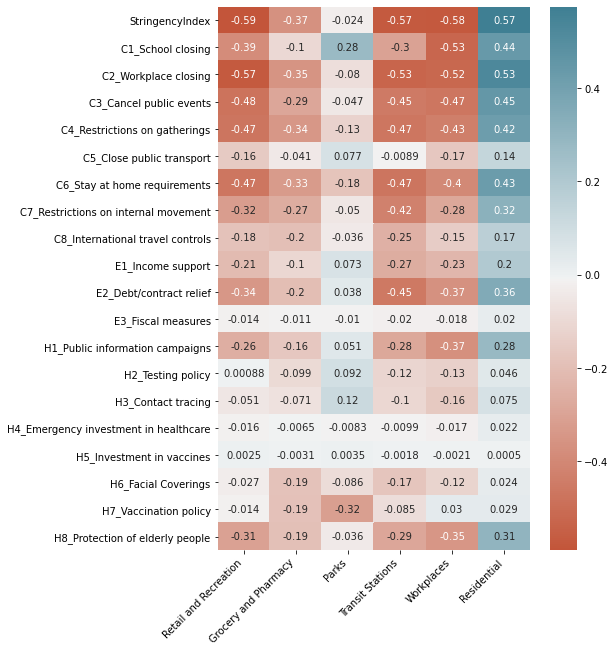

In [20]:
fig, ax = plt.subplots(figsize = (7,10))
sns.heatmap(google_lockdown_corr, annot = True , cmap = myp)
plt.xticks(rotation = 45, horizontalalignment="right");

### Daily cases and deaths vs. mobility by destination (National level)

<AxesSubplot:>

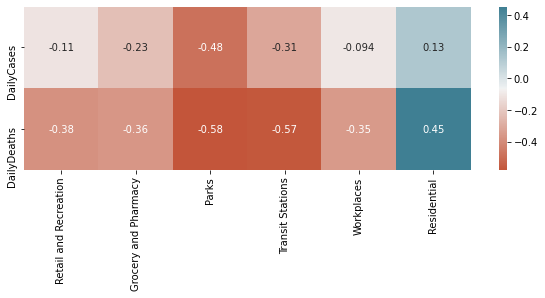

In [21]:
corr = google_lockdown_US[['DailyCases','DailyDeaths']+new_cols].corr().iloc[:2,2:]
fig, ax = plt.subplots(figsize = (10,3))
sns.heatmap(corr, annot = True , cmap = myp)